In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_excel('processed_data.xlsx')

In [ ]:
df

,sample answer,processed response,Marks
0,A problem can be solved in more than one ways....,we need algorithm analysis to verifytest the e...,2.5
1,A problem can be solved in more than one ways....,we need algorithm analysis to determine the co...,2.5
2,A problem can be solved in more than one ways....,we need algorithm analysis so we can analysis ...,2.5
3,A problem can be solved in more than one ways....,we need algorithm analysis for finding the bes...,2.5
4,A problem can be solved in more than one ways....,we require algorithm analysis so that we can a...,2.5
...,...,...,...
2667,"A simple graph is a graph, which has not more ...",graph with only one edge between vertices,2.5
2668,"A simple graph is a graph, which has not more ...",a graph in which each node does not have multi...,2.5
2669,"A simple graph is a graph, which has not more ...",simple graph refers to that graph where all th...,2.5
2670,"A simple graph is a graph, which has not more ...",which has non polynomial time complexity probl...,2.5


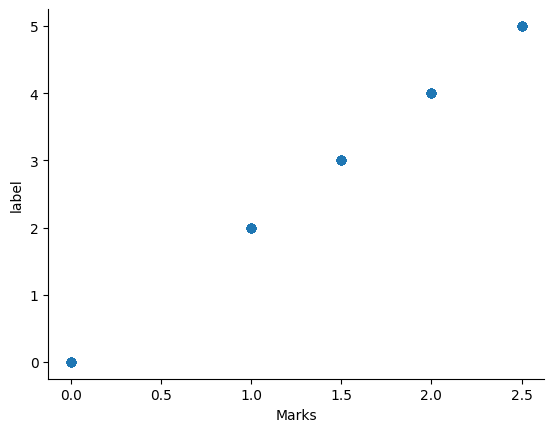

In [ ]:
from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Marks', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

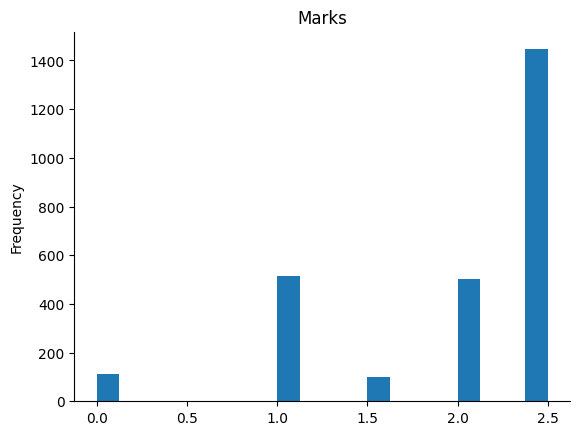

In [ ]:
from matplotlib import pyplot as plt
df['Marks'].plot(kind='hist', bins=20, title='Marks')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Map labels to integers
label_mapping = {0: 0, 0.5: 1, 1: 2, 1.5: 3, 2: 4, 2.5: 5}
df['label'] = df['Marks'].map(label_mapping)

In [ ]:
df

,sample answer,processed response,Marks,label
0,A problem can be solved in more than one ways....,we need algorithm analysis to verifytest the e...,2.5,5
1,A problem can be solved in more than one ways....,we need algorithm analysis to determine the co...,2.5,5
2,A problem can be solved in more than one ways....,we need algorithm analysis so we can analysis ...,2.5,5
3,A problem can be solved in more than one ways....,we need algorithm analysis for finding the bes...,2.5,5
4,A problem can be solved in more than one ways....,we require algorithm analysis so that we can a...,2.5,5
...,...,...,...,...
2667,"A simple graph is a graph, which has not more ...",graph with only one edge between vertices,2.5,5
2668,"A simple graph is a graph, which has not more ...",a graph in which each node does not have multi...,2.5,5
2669,"A simple graph is a graph, which has not more ...",simple graph refers to that graph where all th...,2.5,5
2670,"A simple graph is a graph, which has not more ...",which has non polynomial time complexity probl...,2.5,5


In [ ]:
df.shape

(2672, 4)

In [ ]:
df.head()

,sample answer,processed response,Marks,label
0,A problem can be solved in more than one ways....,we need algorithm analysis to verifytest the e...,2.5,5
1,A problem can be solved in more than one ways....,we need algorithm analysis to determine the co...,2.5,5
2,A problem can be solved in more than one ways....,we need algorithm analysis so we can analysis ...,2.5,5
3,A problem can be solved in more than one ways....,we need algorithm analysis for finding the bes...,2.5,5
4,A problem can be solved in more than one ways....,we require algorithm analysis so that we can a...,2.5,5


In [ ]:
df.isnull().sum()

sample answer         0
processed response    7
Marks                 0
label                 0
dtype: int64

In [ ]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
val_df.shape

(535, 4)

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text_a = str(row['sample answer'])
        text_b = str(row['processed response'])
        label = int(row['label'])

        encoding = self.tokenizer(
            text_a,
            text_b,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
len(label_mapping)

6

In [ ]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Create instances of the custom dataset
train_dataset = CustomDataset(train_df, tokenizer)
val_dataset = CustomDataset(val_df, tokenizer)


In [ ]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Define the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
num_epochs = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
train_losses = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Training Loss: {avg_train_loss:.4f}')


Epoch 1/8: 100%|██████████| 268/268 [03:12<00:00,  1.40it/s]


Epoch 1/8, Average Training Loss: 1.0690


Epoch 2/8: 100%|██████████| 268/268 [03:13<00:00,  1.38it/s]


Epoch 2/8, Average Training Loss: 0.8486


Epoch 3/8: 100%|██████████| 268/268 [03:14<00:00,  1.38it/s]


Epoch 3/8, Average Training Loss: 0.7788


Epoch 4/8: 100%|██████████| 268/268 [03:13<00:00,  1.38it/s]


Epoch 4/8, Average Training Loss: 0.6708


Epoch 5/8: 100%|██████████| 268/268 [03:13<00:00,  1.38it/s]


Epoch 5/8, Average Training Loss: 0.5237


Epoch 6/8: 100%|██████████| 268/268 [03:13<00:00,  1.38it/s]


Epoch 6/8, Average Training Loss: 0.3906


Epoch 7/8: 100%|██████████| 268/268 [03:13<00:00,  1.38it/s]


Epoch 7/8, Average Training Loss: 0.2573


Epoch 8/8: 100%|██████████| 268/268 [03:13<00:00,  1.38it/s]

Epoch 8/8, Average Training Loss: 0.1979


In [ ]:
import matplotlib.pyplot as plt

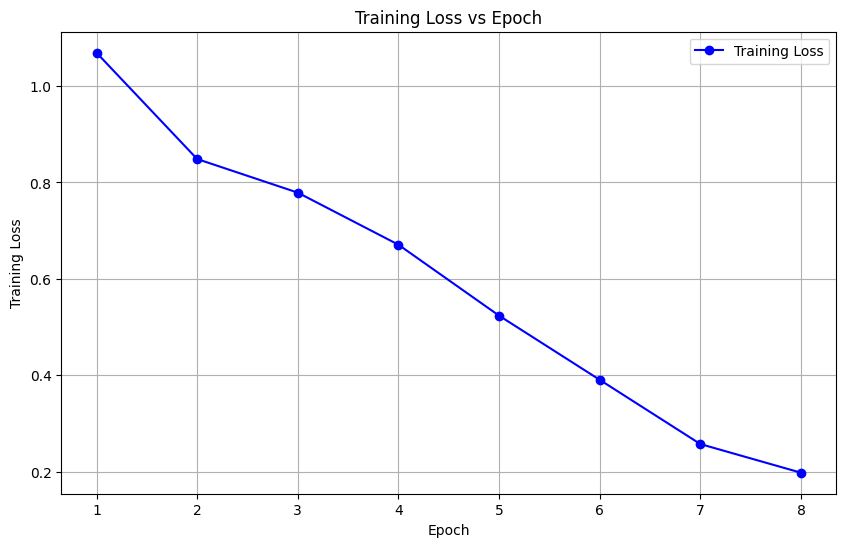

In [ ]:
# Plotting loss vs epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Training Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Validation loop
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Validation'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

Validation: 100%|██████████| 67/67 [00:17<00:00,  3.92it/s]


In [ ]:
# Calculate accuracy on the validation set
val_accuracy = accuracy_score(all_labels, all_predictions)
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.6879


In [ ]:
def predict_grade(sample_response, student_response, model, tokenizer):
    model.eval()

    # Convert to strings
    sample_response = str(sample_response)
    student_response = str(student_response)

    # Tokenize and encode the input
    encoding = tokenizer(
        sample_response,
        student_response,
        truncation=True,
        max_length=512,
        padding='max_length',
        return_tensors='pt'
    )

    # Move tensors to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Make the prediction
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        predicted_label = torch.argmax(outputs.logits, dim=1).item()

    # Map the predicted label back to the original grade
    grade_mapping_reverse = {v: k for k, v in label_mapping.items()}
    predicted_grade = grade_mapping_reverse[predicted_label]

    return predicted_grade, predicted_label


In [ ]:
# Example usage
sample_response = "An algorithm are generally analyzed on two factors − time and space. That is, how much execution time and how much extra space required by the algorithm."
student_response = "An algorithm are generally analyzed on two factors − time and space. That is, how much execution time and how much extra space required by the algorithm."

In [ ]:
# Ensure the sample_response and student_response are strings
sample_response = str(sample_response)
student_response = str(student_response)

In [ ]:
# Make the prediction
predicted_grade, predicted_label = predict_grade(sample_response, student_response, model, tokenizer)

print(f"Predicted Grade: {predicted_grade}")
print(f"Predicted Label: {predicted_label}")

Predicted Grade: 2.5
Predicted Label: 5


In [ ]:
import pandas as pd

# Create an empty DataFrame
result_df = pd.DataFrame(columns=['Sample Response', 'Student Response', 'Actual Grade', 'Predicted Grade', 'Predicted Label'])


In [ ]:
val_df

,sample answer,processed response,Marks,label
2120,The methods to implement stacks are: Array ba...,linked listnarray,2.5,5
1211,Quick sort uses divide and conquer approach. I...,quicks sort works on the principle of divide a...,1.0,2
1461,It depends on how connected the graph is. A co...,a graph can have n spanning trees where n is t...,1.0,2
1511,It depends on how connected the graph is. A co...,if there are n vertices a graph can have n s...,1.0,2
1237,Quick sort uses divide and conquer approach. I...,quick sort is done by taking a random element ...,2.5,5
...,...,...,...,...
1860,Prefix Notation − * + a b + c d Postfix Notat...,prefix notation abcdnpostfix notation abcd,0.0,0
229,"Asymptotic analysis of an algorithm, refers to...",asymptotic analysis is a way to display the ti...,1.0,2
1362,AVL trees are height balancing binary search t...,avl tree is a type of binary search tree with ...,2.5,5
2286,The difference between a binary tree and the t...,in threaded binary tree empty spaces are used ...,2.0,4


In [ ]:
# Populate the DataFrame using val_df
for index, row in val_df.iterrows():
    sample_response = row['sample answer']
    student_response = row['processed response']
    actual_grade = row['Marks']

    # Make the prediction
    predicted_grade, predicted_label = predict_grade(sample_response, student_response, model, tokenizer)

    # Append to the DataFrame
    result_df = pd.concat([result_df, pd.DataFrame({
        'Sample Response': [sample_response],
        'Student Response': [student_response],
        'Actual Grade': [actual_grade],
        'Predicted Grade': [predicted_grade],
        'Predicted Label': [predicted_label]
    })], ignore_index=True)

In [ ]:
result_df

,Sample Response,Student Response,Actual Grade,Predicted Grade,Predicted Label
0,The methods to implement stacks are: Array ba...,linked listnarray,2.5,2.5,5
1,Quick sort uses divide and conquer approach. I...,quicks sort works on the principle of divide a...,1.0,1.0,2
2,It depends on how connected the graph is. A co...,a graph can have n spanning trees where n is t...,1.0,1.0,2
3,It depends on how connected the graph is. A co...,if there are n vertices a graph can have n s...,1.0,1.0,2
4,Quick sort uses divide and conquer approach. I...,quick sort is done by taking a random element ...,2.5,2.0,4
...,...,...,...,...,...
530,Prefix Notation − * + a b + c d Postfix Notat...,prefix notation abcdnpostfix notation abcd,0.0,0.0,0
531,"Asymptotic analysis of an algorithm, refers to...",asymptotic analysis is a way to display the ti...,1.0,2.5,5
532,AVL trees are height balancing binary search t...,avl tree is a type of binary search tree with ...,2.5,1.0,2
533,The difference between a binary tree and the t...,in threaded binary tree empty spaces are used ...,2.0,2.0,4


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
result_df['Actual Grade'] = result_df['Actual Grade'].astype(int)
result_df['Predicted Label'] = result_df['Predicted Label'].astype(int)

In [ ]:
unique_values = list(set(all_predictions))

print(unique_values)

[0, 2, 3, 4, 5]


In [ ]:
from collections import Counter
value_counts = Counter(all_predictions)

# Count occurrences of a particular value, e.g., 2
count_of_2 = value_counts[2]

print(f"Count of 2: {count_of_2}")

Count of 2: 97


In [ ]:
# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)


In [ ]:
conf_matrix

array([[ 12,   5,   0,   1,   5],
       [  2,  62,   0,  20,  18],
       [  0,   3,   6,   7,   5],
       [  0,  17,   5,  60,  24],
       [  0,  10,   4,  41, 228]])

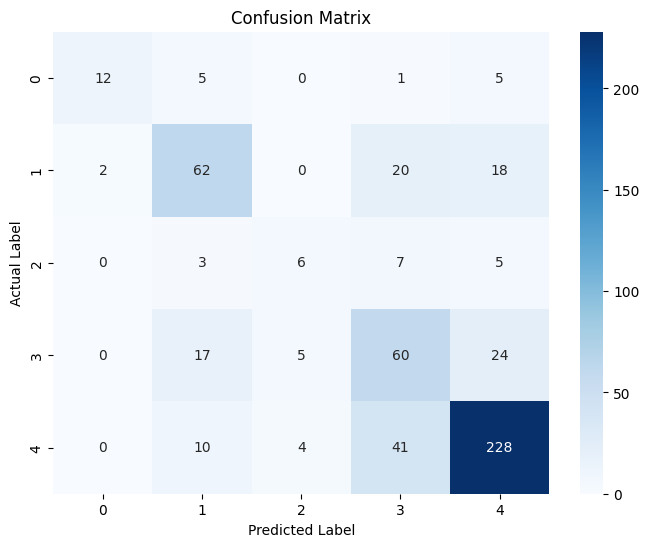

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [ ]:
  # Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None, labels=range(len(label_mapping)))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for i in range(len(label_mapping)):
        print(f'Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1[i]:.4f}')

    # Calculate macro and micro averages
macro_avg_precision, macro_avg_recall, macro_avg_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
micro_avg_precision, micro_avg_recall, micro_avg_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='micro')
print()
print(f'Macro Average: Precision={macro_avg_precision:.4f}, Recall={macro_avg_recall:.4f}, F1 Score={macro_avg_f1:.4f}')
print(f'Micro Average: Precision={micro_avg_precision:.4f}, Recall={micro_avg_recall:.4f}, F1 Score={micro_avg_f1:.4f}')


Class 0: Precision=0.8571, Recall=0.5217, F1 Score=0.6486
Class 1: Precision=0.0000, Recall=0.0000, F1 Score=0.0000
Class 2: Precision=0.6392, Recall=0.6078, F1 Score=0.6231
Class 3: Precision=0.4000, Recall=0.2857, F1 Score=0.3333
Class 4: Precision=0.4651, Recall=0.5660, F1 Score=0.5106
Class 5: Precision=0.8143, Recall=0.8057, F1 Score=0.8099

Macro Average: Precision=0.6351, Recall=0.5574, F1 Score=0.5851
Micro Average: Precision=0.6879, Recall=0.6879, F1 Score=0.6879


In [ ]:
# Specify the directory in Google Drive where you want to save the model
drive_save_directory = '/content/drive/MyDrive/BERT_Models/my_bert_model'

In [ ]:
# Save the model and tokenizer to Google Drive
model.save_pretrained(drive_save_directory)
tokenizer.save_pretrained(drive_save_directory)

print(f'Model and tokenizer saved to {drive_save_directory}')